In [28]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz, load_npz
from scipy.sparse import csr_matrix, save_npz, load_npz
import dask.dataframe as dd
import gc

def batch_cosine_similarity(dtm, batch_size=1000):
    num_rows = dtm.shape[0]
    for start in range(0, num_rows, batch_size):
        end = min(start + batch_size, num_rows)
        yield cosine_similarity(dtm[start:end], dtm)

import psutil
def print_ram_usage(step = 0):
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"[{step}] RAM Usage: {mem_info.rss / (1024 ** 2):.2f} MB")

# # Load data (assuming data is in a CSV file, replace 'data.csv' with your actual file path)
data = pd.read_csv('../int_data/Input_patent_matrix_UK_modern.csv')
data = data.rename(columns = {"publicationnumber":"i"})
data

In [4]:
# TODO: readme

In [8]:
# data.i.nunique(), data.description.nunique(), data.recid.nunique(), data[['recid', 'i']].set_index(['recid', 'i']).index.is_unique, len(data[['recid', 'i']].set_index(['recid', 'i']))
# unique 22,144 patent-inventor pairs

data.i.nunique(), data.description.nunique()

(30646, 29819)

In [9]:
# Count the number of words in the 'description' column
data['strcount'] = data['description'].str.split().str.len()
# Filter the data based on the word count
# Too long or too short patents are filtered
data = data[(data['strcount'] > 10) & (data['strcount'] <= 500)].reset_index(drop = True)
data

,i,publicationdate,title,description,industry_nacerev2,pos2,max,strcount
0,GB2536787A,28/09/2016,PULTRUSION APPARATUS,APPARATUS FIELD INLET SPREADER PRODUCT USE PAR...,2229,-1,53757,470
1,GB2508787A8,10/09/2014,STABLE NON-AQUEOUS ELECTROLYTE PROMOTING IDEAL...,PRESENT LITHIUM BATTERY NEGATIVE ELECTRODE ACT...,4511,-1,426,14
2,GB2508787A,11/06/2014,STABLE NON-AQUEOUS ELECTROLYTE PROMOTING IDEAL...,PRESENT LITHIUM BATTERY NEGATIVE ELECTRODE ACT...,4511,-1,426,14
3,GB2501821B,14/09/2016,MS/MS ANALYSIS USING ECD OR ETD FRAGMENTATION,ANALYSIS FRAGMENTATION BACKGROUND PRESENT METH...,8541,-1,30934,346
4,GB2537930A,02/11/2016,A HYDRAULIC PUMP,HYDRAULIC PUMP KNOWN USE PROVIDE FLOW FLUID MA...,2910,-1,24512,276
...,...,...,...,...,...,...,...,...
23659,GB2462192B,31/10/2012,METHOD OF MANUFACTURING A COMPOSITE FILTER MEDIA,METHOD COMPOSITE FILTER MEDIA BACKGROUND FIELD...,2825,-1,23782,400
23660,GB2503578A,01/01/2014,METHOD AND SYSTEM FOR COUPLING RESERVOIR AND S...,TITLE METHOD SYSTEM COUPLING RESERVOIR SURFACE...,1920,-1,1003,24
23661,GB2487971A,15/08/2012,SKIN SUTURE INSERTION APPARATUS AND DRAIN SECU...,SUTURE INSERTION APPARATUS DRAIN PRESENT SKIN ...,3250,-1,21990,280
23662,GB2477687B,10/04/2013,X-RAY MARKER,MARKER PRESENT PARTICULAR DETERMINE MAGNIFICAT...,3250,-1,22918,360


In [10]:
data['description_len'] = data.description.apply(len)
data['description_len'].value_counts(), data['description_len'].isna().sum()

(description_len
 2516    26
 2268    22
 2902    21
 3036    21
 2147    21
         ..
 1229     1
 4048     1
 4008     1
 773      1
 4117     1
 Name: count, Length: 3624, dtype: int64,
 0)

- All description are present and longer than 0

In [11]:
# data.i.nunique(), data.description.nunique(), data.recid.nunique(), data[['recid', 'i']].set_index(['recid', 'i']).index.is_unique, len(data[['recid', 'i']].set_index(['recid', 'i']))
# unique 22,120 patent-inventor pairs

data.i.nunique(), data.description.nunique() # Two patents share the same description

(23664, 23039)

In [12]:
data.description.value_counts() # the first is a duplication
# Title is not cleaned. It contains info on the industry, but does not equal to industry. We should include it.

description
DIFFUSER FIELD PRESENT HAIR BACKGROUND KNOWN FORM ATTACHMENT ATTACHED OUTLET REDUCE VELOCITY INCIDENT UPON GENERALLY BAFFLE GRILLE CONNECTED AIR INLET TAPERING WALL CHAMBER WITHIN SET UPSTANDING CONTACT USER SUMMARY FIRST LEAST ONE EXTERNAL PLURALITY PART INTERNAL SAID ARRAY PROVIDING PEAK FLOW IMPROVE WAY DISTRIBUTION PREFERABLY PERFORATED PLATE DIFFERENT CONCAVE WHEREAS SUBSTANTIALLY SIZE CIRCULAR TAPER INWARDLY TOWARDS SURFACE DIAMETER NOISE APERTURE PERIMETER SHARPER CURVATURE RADIUS RANGE MAY FORMED METALLIC CASE ETCHING PLASTICS MOLDING EVENLY ENTIRETY DEFINED OUTWARDLY DIRECTION EXTENDING SPACED PREFERRED MIDWAY LEDGE INHIBIT LEAKAGE CONNECTOR SECOND EXAMPLE MALE FEMALE LONGITUDINAL AXIS COMPRISE ANGULAR ALIGNMENT ANGULARLY ALIGN RELATIVE CENTRAL FIXED POSITION CONNECTION SINGLE CENTERED EMBODIMENT ANNULAR SUITABLE USE TYPE CONTENTS INCORPORATED HEREIN HOT SLOT ALTERNATIVE PATTERN CONCENTRIC PREVENT BECOMING CHANNEL EMIT RADIALLY INWARD OUTWARD EMISSION TWO DISTRIBUT

In [13]:
# Create a document-term matrix
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(data['description'])

# Save the DTM as a sparse matrix to avoid memory issues
# save_npz('../int_data/dtm.npz', dtm)
# save_npz('../int_data/US_proxy/dtm.npz', dtm)
import os
os.makedirs('../int_data/UK_modern_proxy')
save_npz('../int_data/UK_modern_proxy/dtm.npz', dtm)

In [12]:
# dtm = load_npz('../int_data/dtm.npz')
dtm = load_npz('../int_data/UK_modern_proxy/dtm.npz') # Shape of dtm: (number of documents, size of the vocabulary)
dtm

<23664x27579 sparse matrix of type '<class 'numpy.int64'>'
	with 7366310 stored elements in Compressed Sparse Row format>

In [13]:
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix

# cosine_similarity(A,B)= ||A||⋅||B|| / (A⋅B)
# 
# Assume dtm is your sparse document-term matrix (csr_matrix)
# Normalize rows of the matrix to have unit length (L2 normalization)
dtm_normalized = normalize(dtm, axis=1, norm='l2')

# # Compute cosine similarity matrix as the dot product of the normalized matrix
cosine_sim_matrix = dtm_normalized @ dtm_normalized.T

# Compute using Numpy
dtm_dense = dtm.toarray()
cosine_sim_matrix = np.dot(dtm_normalized, dtm_normalized.T)

In [14]:
type(cosine_sim_matrix)

scipy.sparse._csr.csr_matrix

In [15]:
import pickle

with open("../int_data/UK_modern_proxy/cosine_sim_matrix.pkl", "wb") as f:
    pickle.dump(cosine_sim_matrix, f)

In [16]:
import pickle
with open("../int_data/UK_modern_proxy/cosine_sim_matrix.pkl", "rb") as f:
    cosine_sim_matrix = pickle.load(f)

# with open("../int_data/UK_modern_proxy/cosine_sim_matrix.pkl", "rb") as f:
#     print(f.read(1000))  # Print the first 100 bytes

# import pickletools
# with open("../int_data/UK_modern_proxy/cosine_sim_matrix.pkl", "rb") as f:
#     pickletools.dis(f) # v

In [17]:
cosine_sim_matrix

<23664x23664 sparse matrix of type '<class 'numpy.float64'>'
	with 558654818 stored elements in Compressed Sparse Row format>

In [18]:
# calculate zero cells
# Given values
total_elements = cosine_sim_matrix.shape[0] * cosine_sim_matrix.shape[1]
non_zero_elements = cosine_sim_matrix.nnz
zero_elements = total_elements - non_zero_elements

zero_elements


1330078

In [32]:
# np.fill_diagonal(cosine_sim_matrix, 0)
cosine_sim_matrix.setdiag(0)

- Explantions for zero cells despite all descriptions are present  
Descriptions may have a very low overlap in terms of vocabulary, leading to zero similarity.  
Descriptions might be very unique with little to no common words.

In [33]:
# symmetry and upper triangle
from scipy.sparse import csr_matrix, triu

# Check if the matrix is square (necessary for symmetry)
if cosine_sim_matrix.shape[0] != cosine_sim_matrix.shape[1]:
    is_symmetric = False
else:
    # Check for symmetry
    is_symmetric = (cosine_sim_matrix != cosine_sim_matrix.transpose()).nnz == 0

if is_symmetric:
    # Extract the upper triangle
    upper_triangle = triu(cosine_sim_matrix)
    print("The matrix is symmetric.")
    # Optionally, convert to dense matrix for inspection (not recommended for large matrices)
    # print(upper_triangle.toarray())
else:
    print("The matrix is not symmetric.")

The matrix is symmetric.


In [34]:
upper_triangle

<23664x23664 sparse matrix of type '<class 'numpy.float64'>'
	with 279339241 stored elements in COOrdinate format>

In [35]:
import pickle

# with open('../int_data/cosine_sim_matrix.pkl','wb') as f:
#     pickle.dump(cosine_sim_matrix,f) # 5.3 GB

with open('../int_data/UK_modern_proxy/cosine_sim_matrix_u.pkl','wb') as f:
    pickle.dump(upper_triangle,f)
    
with open('../int_data/UK_modern_proxy/cosine_sim_matrix_u.pkl','rb') as f:
    upper_triangle = pickle.load(f) # 22,120 unique patent-inventor pairs
upper_triangle

<23664x23664 sparse matrix of type '<class 'numpy.float64'>'
	with 279339241 stored elements in COOrdinate format>

In [30]:
!ls -lha ../int_data/UK_modern_proxy/cosine_sim_matrix_u.pkl

-rw-r--r-- 1 xiet13 cluster-users 4.2G Dec 17 02:05 ../int_data/UK_modern_proxy/cosine_sim_matrix_u.pkl


In [36]:
# Convert the sparse cosine similarity matrix to a DataFrame for further processing
cosine_sim_df = pd.DataFrame.sparse.from_spmatrix(upper_triangle)
cosine_sim_df.reset_index(inplace=True, drop = True)
cosine_sim_df

,0,1,2,3,4,5,6,7,8,9,...,23654,23655,23656,23657,23658,23659,23660,23661,23662,23663
0,0,0.049364,0.049364,0.292137,0.33196,0.270634,0.261099,0.250605,0.293952,0.26226,...,0.093308,0.250833,0.252713,0.258825,0.071251,0.29544,0.065979,0.309067,0.288378,0.309067
1,0,0,1.0,0.072259,0.032292,0.019338,0.083034,0.064466,0.053586,0.045538,...,0,0.060492,0.052868,0.049523,0.041239,0.026929,0,0.047916,0.042435,0.047916
2,0,0,0,0.072259,0.032292,0.019338,0.083034,0.064466,0.053586,0.045538,...,0,0.060492,0.052868,0.049523,0.041239,0.026929,0,0.047916,0.042435,0.047916
3,0,0,0,0,0.222137,0.226933,0.275519,0.247819,0.246653,0.23341,...,0.062439,0.30108,0.213931,0.270531,0.058406,0.223384,0.066227,0.213281,0.228951,0.213281
4,0,0,0,0,0,0.24042,0.228984,0.21858,0.257396,0.226458,...,0.104637,0.25433,0.290793,0.265861,0.065253,0.252612,0.061658,0.296046,0.271775,0.296046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.061702,0.216773,0.239972,0.216773
23660,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.024398,0.021607,0.024398
23661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.328943,1.0
23662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.328943


In [37]:
zero_count = np.sum(cosine_sim_df.values == 0)
zero_count

280669319

In [38]:
cosine_sim_long = pd.melt(cosine_sim_df.reset_index(), id_vars=['index'], var_name='Column', value_name='Value')
cosine_sim_long = cosine_sim_long.rename(columns={'index': 'i'}).reset_index(drop =True)

<Axes: >

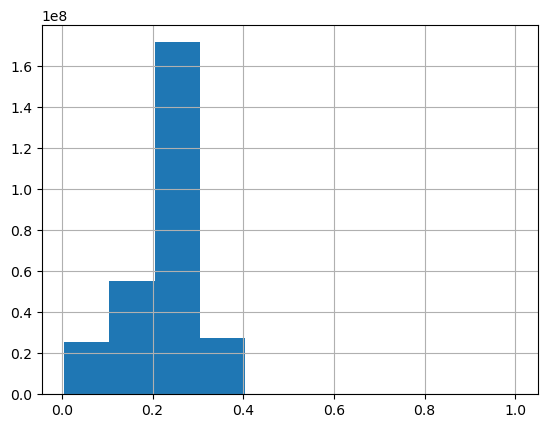

In [39]:
cosine_sim_long = cosine_sim_long[cosine_sim_long.Value > 0]
cosine_sim_long.Value.hist()

In [48]:
cosine_sim_long[cosine_sim_long.Value == 1] # A few patents with identical values

,i,Column,Value
458480,956,960,1.0
5699993,3346,3382,1.0
8742910,4155,4188,1.0
11997430,4890,4906,1.0
17472896,5849,5919,1.0
26177045,7194,7244,1.0
29502794,7394,7690,1.0
33300097,8155,8170,1.0
64308382,11352,11353,1.0
89932352,13424,13425,1.0


In [40]:
cosine_sim_long = cosine_sim_long.reset_index(drop =True)
cosine_sim_long

,i,Column,Value
0,0,1,0.049364
1,0,2,0.049364
2,1,2,1.0
3,0,3,0.292137
4,1,3,0.072259
...,...,...,...
279315572,23658,23663,0.046107
279315573,23659,23663,0.216773
279315574,23660,23663,0.024398
279315575,23661,23663,1.0


In [51]:
cosine_sim_long = cosine_sim_long.rename(columns = {'Column': 'j'})

What happened so far:
- 23,663 patent-industry pairs selected based on approriate strcount of description
- All zero values due to low similarity (dtm) dropped (0.13 billion)
- Picked only the upper triangle

In [52]:
cosine_sim_long

,i,j,Value
0,0,1,0.049364
1,0,2,0.049364
2,1,2,1.0
3,0,3,0.292137
4,1,3,0.072259
...,...,...,...
279315572,23658,23663,0.046107
279315573,23659,23663,0.216773
279315574,23660,23663,0.024398
279315575,23661,23663,1.0


In [91]:
# agg_occ = pd.read_feather('../final_data/UK_modern/agg_occ.feather') # final data example
# agg_occ

,occupation_1,occupation_2,Combined_Value
0,HISCO410,HISCO744,0.166452
1,HISCO410,HISCO896,0.169314
2,HISCO410,HISCO779,0.150686
3,HISCO410,HISCO951,0.156130
4,HISCO410,HISCO813,0.169089
...,...,...,...
59775,HISCO395,HISCO755,0.219659
59776,HISCO395,HISCO641,0.190232
59777,HISCO395,HISCO772,0.102327
59778,HISCO395,HISCO815,0.178434


In [49]:
data

,i,publicationdate,title,description,industry_nacerev2,pos2,max
0,GB2536787A,28/09/2016,PULTRUSION APPARATUS,APPARATUS FIELD INLET SPREADER PRODUCT USE PAR...,2229,-1,53757
1,GB2508787A8,10/09/2014,STABLE NON-AQUEOUS ELECTROLYTE PROMOTING IDEAL...,PRESENT LITHIUM BATTERY NEGATIVE ELECTRODE ACT...,4511,-1,426
2,GB2508787A,11/06/2014,STABLE NON-AQUEOUS ELECTROLYTE PROMOTING IDEAL...,PRESENT LITHIUM BATTERY NEGATIVE ELECTRODE ACT...,4511,-1,426
3,GB2501821B,14/09/2016,MS/MS ANALYSIS USING ECD OR ETD FRAGMENTATION,ANALYSIS FRAGMENTATION BACKGROUND PRESENT METH...,8541,-1,30934
4,GB2511760A,17/09/2014,IMPROVEMENTS RELATING TO TEST DEVICES,TEST FIELD DIAGNOSTIC PARTICULAR INDIVIDUALLY ...,6420,-1,109693
...,...,...,...,...,...,...,...
30641,GB2503578A,01/01/2014,METHOD AND SYSTEM FOR COUPLING RESERVOIR AND S...,TITLE METHOD SYSTEM COUPLING RESERVOIR SURFACE...,1920,-1,1003
30642,GB2492218A,26/12/2012,VIRTUAL MICROSCOPY,INTELLECTUAL PROPERTY OFFICE DATE OCTOBER APPL...,3250,-1,80417
30643,GB2487971A,15/08/2012,SKIN SUTURE INSERTION APPARATUS AND DRAIN SECU...,SUTURE INSERTION APPARATUS DRAIN PRESENT SKIN ...,3250,-1,21990
30644,GB2477687B,10/04/2013,X-RAY MARKER,MARKER PRESENT PARTICULAR DETERMINE MAGNIFICAT...,3250,-1,22918


In [53]:
# Merge data to get 'occhisco_i' and 'occhisco_j'
occ_col = 'industry_nacerev2'
cosine_sim_long = pd.merge(cosine_sim_long, data[[occ_col]], left_on='i', right_index=True, how='left')
cosine_sim_long = cosine_sim_long.rename(columns={occ_col: 'occ_i'})
cosine_sim_long = pd.merge(cosine_sim_long, data[[occ_col]], left_on='j', right_index=True, how='left')
cosine_sim_long = cosine_sim_long.rename(columns={occ_col: 'occ_j'})
print("merge done")

merge done


In [54]:
import pickle

with open('../int_data/UK_modern_proxy/cosine_sim_long.pkl','wb') as f:
     pickle.dump(cosine_sim_long, f)

In [8]:
import pickle

with open('../int_data/UK_modern_proxy/cosine_sim_long.pkl','rb') as f:
    cosine_sim_long = pickle.load(f)

In [9]:
cosine_sim_long.occ_i.nunique(), cosine_sim_long.occ_j.nunique(), cosine_sim_long.i.nunique(), cosine_sim_long.j.nunique()

(393, 393, 23663, 23663)

In [59]:
cosine_sim_long

,i,j,Value,occ_i,occ_j
0,0,1,0.049364,2229,4511
1,0,2,0.049364,2229,4511
2,1,2,1.0,4511,4511
3,0,3,0.292137,2229,8541
4,1,3,0.072259,4511,8541
...,...,...,...,...,...
279315572,23658,23663,0.046107,6203,2812
279315573,23659,23663,0.216773,6203,2812
279315574,23660,23663,0.024398,6203,2812
279315575,23661,23663,1.0,6203,2812


In [60]:
print_ram_usage()

[0] RAM Usage: 81227.25 MB


In [5]:
tab_i = dict(zip(cosine_sim_long['i'], cosine_sim_long['occ_i']))
tab_j = dict(zip(cosine_sim_long['j'], cosine_sim_long['occ_j']))
tab_i.update(tab_j)
combined_mapping = tab_i

In [56]:
# tab_i = dict(zip(cosine_sim_long['i'], cosine_sim_long['occ_i']))
# tab_j = dict(zip(cosine_sim_long['j'], cosine_sim_long['occ_j']))

# # Combine the dictionaries
# # We'll combine occ_i_map and occ_j_map such that all keys are included, 
# # and for overlapping keys, we can use either occ_i or occ_j based on your choice
# combined_mapping = {key: (tab_i.get(key, None), tab_j.get(key, None)) for key in set(tab_i) | set(tab_j)}

# # # Ensure first and last keys from both mappings are included in the final result
# first_i = cosine_sim_long['i'].iloc[0]
# last_i = cosine_sim_long['i'].iloc[-1]
# first_j = cosine_sim_long['j'].iloc[0]
# last_j = cosine_sim_long['j'].iloc[-1]

# combined_mapping[first_i] = (tab_i.get(first_i, None), tab_j.get(first_i, None))
# combined_mapping[last_i] = (tab_i.get(last_i, None), tab_j.get(last_i, None))
# combined_mapping[first_j] = (tab_i.get(first_j, None), tab_j.get(first_j, None))
# combined_mapping[last_j] = (tab_i.get(last_j, None), tab_j.get(last_j, None))

# # Check the result
# for key, value in combined_mapping.items():
#     if value[0] is None:
#         # If the first value is None, keep the second value
#         data[key] = value[1]
#     elif value[1] is None:
#         # If the second value is None, keep the first value
#         data[key] = value[0]
#     elif value[0] == value[1]:
#         # If both values are the same, keep just one as an integer
#         data[key] = value[0]
#     else:
#         # If the values are different, raise an error
#         raise ValueError(f"Values for key {key} are not identical: {value}")


NameError: name 'data' is not defined

In [21]:
cosine_sim_long.occ_i.nunique(), cosine_sim_long.occ_j.nunique()

(393, 393)

# New: Aggregate kw similarity by occupations
time complexity: O(n*n * m * m), where n is number of keywords, m is number of patents

### Create empty occ space

In [63]:
# i_occ_mapping = data_explode_pre.reset_index()
# i_occ_mapping.census_occupation[1] # many repeated occ strings in one census_occupation, e.g., 'HISCO745'

NameError: name 'data_explode_pre' is not defined

In [14]:
# i_occ_mapping.census_occupation = i_occ_mapping.census_occupation.apply(lambda x:list(set(x)))
# i_occ_mapping

,index,i,census_occupation
0,0,GB187303416,"[HISCO744, HISCO410, HISCO896]"
1,1,GB187600824,"[HISCO974, HISCO779, HISCO745, HISCO896, HISCO..."
2,2,GB187601544,"[HISCO999, HISCO901, HISCO24, HISCO90, HISCO97..."
3,3,GB188204200,"[HISCO799, HISCO231, HISCO79, HISCO894, HISCO9..."
4,4,GB188803213,[HISCO777]
...,...,...,...
22115,22115,GB191211210,[NA]
22116,22116,GB191213037,"[HISCO999, HISCO333, HISCO33]"
22117,22117,GB191213039,"[HISCO999, HISCO333, HISCO33]"
22118,22118,GB191217939,"[HISCO999, HISCO333, HISCO33]"


In [15]:
# i_occ_mapping.i.nunique() # does not correspond to 22,120 unique patent-inventor pairs


20742

- We choose index (which exactly matches "data" on shape[0]) to form the index:census_occupation mappings

In [16]:
# # get all occs

# i_occ_mapping['mapping'] = i_occ_mapping.apply(lambda x:{x['index']:x.census_occupation}, axis = 1)
# combined_mapping = {}
# i_occ_mapping['mapping'].apply(lambda x:combined_mapping.update(x))

# combined_mapping

{0: ['HISCO744', 'HISCO410', 'HISCO896'],
 1: ['HISCO974',
  'HISCO779',
  'HISCO745',
  'HISCO896',
  'HISCO813',
  'HISCO391',
  'HISCO951',
  'HISCO397'],
 2: ['HISCO999', 'HISCO901', 'HISCO24', 'HISCO90', 'HISCO974', 'HISCO397'],
 3: ['HISCO799',
  'HISCO231',
  'HISCO79',
  'HISCO894',
  'HISCO931',
  'HISCO161',
  'HISCO391',
  'HISCO949',
  'HISCO221',
  'HISCO23',
  'HISCO22',
  'HISCO443'],
 4: ['HISCO777'],
 5: ['HISCO712', 'HISCO779', 'HISCO71', 'HISCO745'],
 6: ['HISCO24', 'HISCO33', 'HISCO331'],
 7: ['HISCO22'],
 8: ['HISCO22'],
 9: ['HISCO857'],
 10: ['HISCO981'],
 11: ['HISCO410', 'HISCO11', 'HISCO67'],
 12: ['HISCO999', 'HISCO333', 'HISCO33'],
 13: ['NA'],
 14: ['NA'],
 15: ['NA'],
 16: ['HISCO410', 'HISCO24', 'HISCO776'],
 17: ['HISCO754', 'HISCO79', 'HISCO24', 'HISCO75', 'HISCO799'],
 18: ['NA'],
 19: ['HISCO895', 'HISCO893'],
 20: ['NA'],
 21: ['NA'],
 22: ['NA'],
 23: ['NA'],
 24: ['HISCO942'],
 25: ['HISCO999', 'HISCO333', 'HISCO33', 'HISCO430'],
 26: ['HISCO999', 

In [17]:
# len(combined_mapping)

22120

In [2]:
# !ls -lha ../int_data/combined_mapping.pkl

-rw-r--r-- 1 xiet13 cluster-users 0 Aug  7 10:23 ../int_data/combined_mapping.pkl


In [4]:
# import pickle
# with open('../int_data/combined_mapping.pkl','wb') as f:
#     pickle.dump(combined_mapping, f)

NameError: name 'combined_mapping' is not defined

In [5]:
# import pickle

# with open('../int_data/combined_mapping.pkl','rb') as f:
#     combined_mapping = pickle.load(f)

EOFError: Ran out of input

In [25]:
cosine_sim_long # each patent only has 1 occ already

,i,j,Value,occ_i,occ_j
0,0,1,0.049364,2229,4511
1,0,2,0.049364,2229,4511
2,1,2,1.0,4511,4511
3,0,3,0.292137,2229,8541
4,1,3,0.072259,4511,8541
...,...,...,...,...,...
279315572,23658,23663,0.046107,6203,2812
279315573,23659,23663,0.216773,6203,2812
279315574,23660,23663,0.024398,6203,2812
279315575,23661,23663,1.0,6203,2812


In [6]:
# create empty occ_space
all_occs = cosine_sim_long.occ_i.unique().tolist()
matrix_of_3_dim_empty_lists = [[[] for _ in all_occs] for _ in all_occs] # 245*245*1
occ_space = pd.DataFrame(matrix_of_3_dim_empty_lists, index=all_occs, columns=all_occs)

# Set the diagonal elements to 0
for i in all_occs:
    occ_space.at[i, i] = 0
occ_space

,2229,4511,8541,6420,2910,2790,2611,2670,7010,2599,...,9313,2895,1032,3012,8211,1711,4313,3821,9602,4742
2229,0,[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
4511,[],0,[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
8541,[],[],0,[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
6420,[],[],[],0,[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
2910,[],[],[],[],0,[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1711,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],0,[],[],[],[]
4313,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],0,[],[],[]
3821,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],0,[],[]
9602,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],0,[]


In [ ]:
# import pickle
# with open('../int_data/occ_space_empty.pkl','wb') as f:
#     pickle.dump(occ_space, f)

In [6]:
# import pickle

# with open('../int_data/occ_space_empty.pkl','rb') as f:
#     occ_space = pickle.load(f)

### Populate

In [29]:
print_ram_usage()

[0] RAM Usage: 20631.39 MB


In [2]:
import pickle
import pandas as pd

with open('../int_data/UK_modern_proxy/cosine_sim_long.pkl','rb') as f:
    cosine_sim_long = pickle.load(f)
cosine_sim_long

/users/xiet13/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,i,j,Value,occ_i,occ_j
0,0,1,0.049364,2229,4511
1,0,2,0.049364,2229,4511
2,1,2,1.0,4511,4511
3,0,3,0.292137,2229,8541
4,1,3,0.072259,4511,8541
...,...,...,...,...,...
279315572,23658,23663,0.046107,6203,2812
279315573,23659,23663,0.216773,6203,2812
279315574,23660,23663,0.024398,6203,2812
279315575,23661,23663,1.0,6203,2812


In [30]:
cosine_sim_long.Value.value_counts()

Value
0.069007    8648
0.074536    8414
0.072169    6762
0.077152    6717
0.062994    6492
            ... 
0.201558       1
0.203617       1
0.155984       1
0.130754       1
0.131941       1
Name: count, Length: 4493116, dtype: int64

In [86]:
cosine_sim_long[cosine_sim_long.occ_i == cosine_sim_long.occ_j] # 

,i,j,Value,occ_i,occ_j
2,1,2,1.0,4511,4511
14,4,5,0.24042,6420,6420
90,12,13,0.45561,8299,8299
103,12,14,0.484719,8299,8299
104,13,14,0.473151,8299,8299
...,...,...,...,...,...
279311545,19623,23663,0.249161,2812,2812
279311546,19624,23663,0.254117,2812,2812
279311547,19625,23663,0.322847,2812,2812
279311548,19626,23663,0.173157,2812,2812


In [14]:

# populate_occ_space(cosine_sim_long.loc[0])
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import math

tqdm.pandas()
larger_index = occ_space.columns

def populate_occ_space(row):
    i = row['i']
    j = row['j']
    v = row['Value']

    # index_i = [x for x in combined_mapping.get(i, []) if (x != 'NA' and x != np.nan)]
    # index_j = [x for x in combined_mapping.get(j, []) if (x != 'NA' and x != np.nan)]

    index_i = combined_mapping.get(i, None) # We are sure it's one single value
    index_j = combined_mapping.get(j, None)

    # index_i = [x for x in index_i if x not in overlap] # avoid measuring similarity between an occupation and itself
    # index_j = [x for x in index_j if x not in overlap]
    
    if index_i != index_j:
        return {(index_i, index_j):v}
    else:
        return {(index_i, index_j):0} # a occ to itself should be 0 (was 1)

def save_intermediate_results(df, filename, chunk_idx):
    df.to_pickle(filename)
    print(f"saved success! batch {chunk_idx}")

def process_chunk(args):
    df, chunk_idx, output_dir, batch_size = args
    print(f"Processing batch {chunk_idx}...")
    print(chunk_idx, chunk_idx+batch_size)
    chunk = df[chunk_idx: chunk_idx+batch_size]
    chunk_results = chunk.progress_apply(populate_occ_space, axis=1)
    
    combined_results = {}
    
    for result in chunk_results:
        # print(result)
        for key, values in result.items():
            if key not in combined_results:
                combined_results[key] = []
            # print(combined_results)
            # print(key)
            combined_results[key].append(values)
            
    
    result_df = pd.DataFrame(index=larger_index, columns=larger_index)
    for (ii, jj), values in combined_results.items():
        result_df.at[ii, jj] = values
    # print(result_df)
    # Save intermediate result
    save_intermediate_results(result_df, os.path.join(output_dir, f"occ_space_chunk_{chunk_idx}_{chunk_idx+batch_size}.pkl"), chunk_idx)

def run_parallel_processing(df, output_dir, batch_size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Determine starting index by checking existing files in the output directory
    existing_files = [f for f in os.listdir(output_dir) if f.endswith('.pkl')]
    start_idx = max([int(f.split('_')[-1].split('.')[0]) for f in existing_files], default=0)
    print(start_idx)
    
        
    # chunks = [df[i:i + batch_size] for i in range(0, len(df), batch_size)]
    # for i in range(start_idx, len(df), batch_size):
    #     process_chunk((cosine_sim_long, i, output_dir, batch_size))
    with Pool(cpu_count()) as pool:
        # Generate arguments for each chunk
        args_list = [(df, i, output_dir, batch_size) for i in range(start_idx, len(df), batch_size)]
        
        # Use pool.map or pool.starmap to process chunks in parallel
        pool.map(process_chunk, args_list)

# def process_chunk(args):
#     df, chunk_idx, output_dir, batch_size = args
#     print(f"Processing batch {chunk_idx}...")
#     chunk = df[chunk_idx: chunk_idx+batch_size]
#     chunk_results = chunk.progress_apply(populate_occ_space, axis=1)
    
#     combined_results = {}
#     for result in chunk_results:
#         for key, values in result.items():
#             if key not in combined_results:
#                 combined_results[key] = []
#             combined_results[key].extend(values)
    
#     result_df = pd.DataFrame(index=larger_index, columns=larger_index)
#     for (ii, jj), values in combined_results.items():
#         result_df.at[ii, jj] = values

#     # Save intermediate result
#     save_intermediate_results(result_df, os.path.join(output_dir, f"occ_space_chunk_{chunk_idx}_{chunk_idx+batch_size}.pkl"), chunk_idx)

# def run_parallel_processing(df, output_dir, batch_size):
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     # Determine starting index by checking existing files in the output directory
#     existing_files = [f for f in os.listdir(output_dir) if f.endswith('.pkl')]
#     start_idx = max([int(f.split('_')[-1].split('.')[0]) for f in existing_files], default=0)
#     print(f"Starting from index: {start_idx}")

#     # Prepare arguments for each chunk
#     chunks = [(df, i, output_dir, batch_size) for i in range(start_idx, len(df), batch_size)]
    
#     # Process chunks in parallel
#     with Pool(cpu_count()-2) as pool:
#         pool.map(process_chunk, chunks)
        
output_dir = "../int_data/occ_UK_modern_space_chunks"
import os 
os.makedirs(output_dir, exist_ok = True)
# Run parallel processing and save intermediate results
batch_size = 200000  # Customize batch size as needed
run_parallel_processing(cosine_sim_long, "../int_data/occ_UK_modern_space_chunks", batch_size)


169200000
Processing batch 169200000...
169200000 169400000


100%|██████████| 200000/200000 [00:24<00:00, 8037.16it/s]


saved success! batch 169200000
Processing batch 169400000...
169400000 169600000


  5%|▌         | 10607/200000 [00:01<00:22, 8269.98it/s]

Processing batch 170200000...
170200000 170400000


 96%|█████████▌| 191272/200000 [00:23<00:01, 8221.56it/s]

saved success! batch 169400000
Processing batch 169600000...
169600000 169800000


  5%|▍         | 9835/200000 [00:01<00:22, 8298.35it/s]

saved success! batch 170200000
Processing batch 170400000...
170400000 170600000


 10%|█         | 20622/200000 [00:02<00:21, 8290.74it/s]

Processing batch 171200000...
171200000 171400000


 91%|█████████ | 182046/200000 [00:22<00:02, 8255.49it/s]

saved success! batch 169600000
Processing batch 169800000...
169800000 170000000


  5%|▌         | 10612/200000 [00:01<00:23, 8207.32it/s]]

saved success! batch 170400000


 98%|█████████▊| 195285/200000 [00:24<00:00, 8233.33it/s]

Processing batch 170600000...
170600000 170800000


  3%|▎         | 6462/200000 [00:00<00:23, 8198.66it/s]]

saved success! batch 171200000


 10%|▉         | 19707/200000 [00:02<00:21, 8258.21it/s]

Processing batch 171400000...
171400000 171600000


  2%|▏         | 3154/200000 [00:00<00:24, 8025.73it/s]]

Processing batch 172200000...
172200000 172400000


 88%|████████▊ | 176228/200000 [00:22<00:02, 8091.43it/s]

saved success! batch 169800000
Processing batch 170000000...
170000000 170200000


 98%|█████████▊| 195185/200000 [00:24<00:00, 8181.73it/s]

saved success! batch 170600000


 95%|█████████▌| 190181/200000 [00:24<00:01, 8201.87it/s]

Processing batch 170800000...
170800000 171000000


 10%|▉         | 19645/200000 [00:02<00:22, 7995.03it/s]]

saved success! batch 171400000
Processing batch 171600000...
171600000 171800000


  2%|▏         | 3981/200000 [00:00<00:24, 8096.29it/s]]

saved success! batch 172200000
Processing batch 172400000...
172400000 172600000


 19%|█▊        | 37010/200000 [00:04<00:19, 8255.59it/s]

Processing batch 173200000...
173200000 173400000


 82%|████████▏ | 164864/200000 [00:20<00:04, 8233.18it/s]

saved success! batch 170000000


 90%|████████▉ | 179650/200000 [00:22<00:02, 8163.72it/s]

saved success! batch 170800000


 99%|█████████▊| 197303/200000 [00:24<00:00, 8169.36it/s]

Processing batch 171000000...
171000000 171200000


 93%|█████████▎| 186235/200000 [00:23<00:01, 8212.49it/s]

saved success! batch 171600000


  2%|▏         | 4833/200000 [00:00<00:23, 8195.45it/s]s]

Processing batch 171800000...
171800000 172000000


 98%|█████████▊| 195261/200000 [00:24<00:00, 8166.32it/s]

saved success! batch 172400000


  4%|▎         | 7257/200000 [00:00<00:23, 8175.13it/s]]

Processing batch 172600000...
172600000 172800000


  8%|▊         | 15462/200000 [00:01<00:22, 8198.78it/s]

saved success! batch 173200000


  3%|▎         | 6446/200000 [00:00<00:23, 8174.00it/s]

Processing batch 173400000...
173400000 173600000


  9%|▉         | 18018/200000 [00:02<00:22, 8257.28it/s]

Processing batch 174200000...
174200000 174400000


 84%|████████▎ | 167413/200000 [00:21<00:03, 8243.64it/s]

saved success! batch 171000000


 97%|█████████▋| 194023/200000 [00:24<00:00, 8158.64it/s]

saved success! batch 171800000


 87%|████████▋ | 174827/200000 [00:22<00:03, 8105.63it/s]

Processing batch 172000000...
172000000 172200000


 98%|█████████▊| 195038/200000 [00:24<00:00, 8202.45it/s]

saved success! batch 172600000
Processing batch 172800000...
172800000 173000000


 96%|█████████▋| 192901/200000 [00:24<00:00, 8247.68it/s]

saved success! batch 173400000


  8%|▊         | 16393/200000 [00:02<00:22, 8244.55it/s]

Processing batch 173600000...
173600000 173800000


  9%|▊         | 17112/200000 [00:02<00:22, 8210.25it/s]

saved success! batch 174200000
Processing batch 174400000...
174400000 174600000


 15%|█▍        | 29438/200000 [00:03<00:20, 8217.64it/s]

Processing batch 175200000...
175200000 175400000


 96%|█████████▋| 192589/200000 [00:24<00:00, 8147.68it/s]

saved success! batch 172000000


 97%|█████████▋| 194857/200000 [00:24<00:00, 8152.55it/s]

saved success! batch 172800000
Processing batch 173000000...
173000000 173200000


  3%|▎         | 6453/200000 [00:00<00:23, 8189.52it/s]s]

saved success! batch 173600000


 91%|█████████▏| 182964/200000 [00:22<00:02, 8247.71it/s]

Processing batch 173800000...
173800000 174000000


  5%|▍         | 9700/200000 [00:01<00:23, 8192.70it/s]s]

saved success! batch 174400000
Processing batch 174600000...
174600000 174800000


  9%|▉         | 18740/200000 [00:02<00:22, 8211.67it/s]

saved success! batch 175200000


  4%|▎         | 7125/200000 [00:00<00:24, 7998.77it/s]

Processing batch 175400000...
175400000 175600000


 10%|█         | 20202/200000 [00:02<00:21, 8189.21it/s]

Processing batch 176200000...

 25%|██▌       | 50216/200000 [00:06<00:18, 8216.78it/s]


176200000 176400000


 87%|████████▋ | 173942/200000 [00:21<00:03, 8161.28it/s]

saved success! batch 173000000


 91%|█████████▏| 182899/200000 [00:22<00:02, 8117.64it/s]

saved success! batch 173800000


 81%|████████  | 161634/200000 [00:20<00:04, 8175.31it/s]

Processing batch 174000000...
174000000 174200000


  5%|▍         | 9736/200000 [00:01<00:23, 8215.62it/s]s]

saved success! batch 174600000
Processing batch 174800000...
174800000 175000000


  9%|▉         | 18786/200000 [00:02<00:22, 8206.77it/s]]

saved success! batch 175400000
Processing batch 175600000...
175600000 175800000


 14%|█▍        | 27735/200000 [00:03<00:25, 6850.51it/s]

saved success! batch 176200000


 10%|▉         | 19528/200000 [00:02<00:22, 8193.04it/s]

Processing batch 176400000...
176400000 176600000


 20%|██        | 40795/200000 [00:05<00:19, 8152.86it/s]

Processing batch 177200000...
177200000 177400000


 80%|████████  | 160662/200000 [00:20<00:04, 8115.77it/s]

saved success! batch 174000000


 87%|████████▋ | 173678/200000 [00:21<00:03, 8101.73it/s]

saved success! batch 174800000


 77%|███████▋  | 154901/200000 [00:19<00:05, 8252.76it/s]

Processing batch 175000000...
175000000 175200000


  3%|▎         | 5583/200000 [00:00<00:23, 8100.95it/s]s]

saved success! batch 175600000
Processing batch 175800000...
175800000 176000000


 10%|█         | 20503/200000 [00:02<00:21, 8242.46it/s]]

saved success! batch 176400000


 14%|█▍        | 28624/200000 [00:03<00:20, 8168.27it/s]]

Processing batch 176600000...
176600000 176800000


 19%|█▉        | 37732/200000 [00:04<00:20, 8099.90it/s]

saved success! batch 177200000
Processing batch 177400000...
177400000 177600000


 22%|██▏       | 44699/200000 [00:05<00:19, 8172.74it/s]

Processing batch 178200000...
178200000 178400000


 98%|█████████▊| 195127/200000 [00:24<00:00, 7579.49it/s]

saved success! batch 175000000


 81%|████████▏ | 162934/200000 [00:20<00:04, 8106.65it/s]

saved success! batch 175800000


 68%|██████▊   | 136360/200000 [00:16<00:07, 8280.10it/s]

Processing batch 176000000...
176000000 176200000


 10%|█         | 20525/200000 [00:02<00:21, 8274.75it/s]]

saved success! batch 176600000


 79%|███████▉  | 158760/200000 [00:19<00:04, 8268.74it/s]

Processing batch 176800000...
176800000 177000000


 20%|█▉        | 39523/200000 [00:04<00:19, 8243.23it/s]]

saved success! batch 177400000


 89%|████████▉ | 177847/200000 [00:21<00:02, 8233.51it/s]

Processing batch 177600000...
177600000 177800000


 12%|█▏        | 23727/200000 [00:02<00:21, 8223.89it/s]

saved success! batch 178200000


 33%|███▎      | 66060/200000 [00:08<00:16, 8291.75it/s]

Processing batch 178400000...
178400000 178600000


 33%|███▎      | 66823/200000 [00:08<00:16, 8125.60it/s]

Processing batch 179200000...
179200000 179400000


 80%|███████▉  | 159872/200000 [00:19<00:04, 8062.56it/s]

saved success! batch 176000000


 93%|█████████▎| 186065/200000 [00:23<00:01, 8088.79it/s]

saved success! batch 176800000


 69%|██████▊   | 137100/200000 [00:16<00:07, 8230.81it/s]

Processing batch 177000000...
177000000 177200000


  8%|▊         | 15506/200000 [00:01<00:22, 8193.87it/s]]

saved success! batch 177600000
Processing batch 177800000...
177800000 178000000


 90%|█████████ | 180021/200000 [00:22<00:02, 8252.56it/s]

saved success! batch 178400000
Processing batch 178600000...

 21%|██        | 41766/200000 [00:05<00:19, 8162.91it/s]


178600000 178800000


 10%|█         | 20400/200000 [00:02<00:21, 8211.35it/s]

saved success! batch 179200000


 23%|██▎       | 46512/200000 [00:05<00:19, 8053.21it/s]

Processing batch 179400000...
179400000 179600000


 11%|█         | 21954/200000 [00:02<00:21, 8178.68it/s]

Processing batch 180200000...
180200000 180400000


 93%|█████████▎| 185852/200000 [00:23<00:01, 8186.55it/s]

saved success! batch 177000000


 78%|███████▊  | 156085/200000 [00:19<00:05, 8131.23it/s]

saved success! batch 177800000


 90%|████████▉ | 179864/200000 [00:22<00:02, 8182.94it/s]

Processing batch 178000000...
178000000 178200000


 90%|████████▉ | 179612/200000 [00:22<00:02, 8074.05it/s]

saved success! batch 178600000


 11%|█         | 22168/200000 [00:02<00:21, 8268.23it/s]

Processing batch 178800000...
178800000 179000000


 91%|█████████ | 181330/200000 [00:22<00:02, 8271.52it/s]

saved success! batch 179400000


 23%|██▎       | 46930/200000 [00:05<00:18, 8211.30it/s]

Processing batch 179600000...
179600000 179800000


 10%|▉         | 19494/200000 [00:02<00:22, 8194.96it/s]

saved success! batch 180200000
Processing batch 180400000...
180400000 180600000


 13%|█▎        | 25145/200000 [00:03<00:22, 7820.17it/s]

Processing batch 181200000...
181200000 181400000


 90%|████████▉ | 179604/200000 [00:22<00:02, 8163.80it/s]

saved success! batch 178000000


 89%|████████▉ | 177916/200000 [00:22<00:02, 8085.96it/s]

saved success! batch 178800000


 78%|███████▊  | 156963/200000 [00:19<00:05, 8103.34it/s]

Processing batch 179000000...
179000000 179200000


 91%|█████████ | 182124/200000 [00:22<00:02, 8066.09it/s]

saved success! batch 179600000


 78%|███████▊  | 155617/200000 [00:19<00:05, 8177.45it/s]

Processing batch 179800000...
179800000 180000000


 10%|▉         | 19554/200000 [00:02<00:22, 8185.19it/s]]

saved success! batch 180400000


 89%|████████▉ | 177789/200000 [00:21<00:02, 8158.67it/s]

Processing batch 180600000...
180600000 180800000


 12%|█▏        | 23708/200000 [00:02<00:21, 8179.88it/s]

saved success! batch 181200000
Processing batch 181400000...
181400000 181600000


 13%|█▎        | 26901/200000 [00:03<00:21, 8059.24it/s]]

Processing batch 182200000...
182200000 182400000


 65%|██████▍   | 129524/200000 [00:16<00:08, 8158.79it/s]

saved success! batch 179000000


 92%|█████████▏| 183450/200000 [00:22<00:02, 8132.08it/s]

saved success! batch 179800000
Processing batch 180000000...
180000000 180200000


 75%|███████▍  | 149275/200000 [00:18<00:06, 8190.70it/s]

saved success! batch 180600000
Processing batch 180800000...
180800000 181000000


 88%|████████▊ | 176471/200000 [00:21<00:02, 8147.99it/s]

saved success! batch 181400000


 23%|██▎       | 45583/200000 [00:05<00:18, 8135.74it/s]

Processing batch 181600000...
181600000 181800000


 35%|███▌      | 70983/200000 [00:08<00:19, 6573.99it/s]

saved success! batch 182200000


 12%|█▏        | 24547/200000 [00:03<00:21, 8226.80it/s]

Processing batch 182400000...
182400000 182600000


 49%|████▉     | 98882/200000 [00:12<00:12, 8178.58it/s]

Processing batch 183200000...


 13%|█▎        | 25319/200000 [00:03<00:21, 8119.61it/s]

183200000 183400000


 91%|█████████ | 181785/200000 [00:22<00:02, 8134.46it/s]

saved success! batch 180000000


 63%|██████▎   | 126225/200000 [00:15<00:08, 8238.58it/s]

saved success! batch 180800000
Processing batch 181000000...
181000000 181200000


 11%|█         | 21934/200000 [00:02<00:21, 8176.38it/s]]

saved success! batch 181600000
Processing batch 181800000...
181800000 182000000


 12%|█▏        | 23732/200000 [00:02<00:21, 8233.65it/s]]

saved success! batch 182400000


 12%|█▏        | 24556/200000 [00:03<00:21, 8231.30it/s]]

Processing batch 182600000...
182600000 182800000


 25%|██▍       | 49898/200000 [00:06<00:18, 8157.85it/s]

saved success! batch 183200000


 12%|█▏        | 24594/200000 [00:03<00:21, 8210.99it/s]

Processing batch 183400000...
183400000 183600000


 27%|██▋       | 54771/200000 [00:06<00:17, 8193.48it/s]]

Processing batch 184200000...
184200000 184400000


 90%|████████▉ | 179617/200000 [00:22<00:02, 8116.60it/s]

saved success! batch 181000000


 89%|████████▉ | 177533/200000 [00:21<00:02, 8075.51it/s]

saved success! batch 181800000


 61%|██████▏   | 122578/200000 [00:15<00:09, 8225.37it/s]

Processing batch 182000000...
182000000 182200000


 12%|█▏        | 23581/200000 [00:02<00:21, 8141.61it/s]]

saved success! batch 182600000
Processing batch 182800000...
182800000 183000000


 12%|█▏        | 23665/200000 [00:02<00:21, 8201.72it/s]]

saved success! batch 183400000


 25%|██▍       | 49752/200000 [00:06<00:18, 8179.14it/s]

Processing batch 183600000...
183600000 183800000


 39%|███▉      | 78310/200000 [00:09<00:16, 7532.67it/s]

saved success! batch 184200000
Processing batch 184400000...
184400000 184600000


 57%|█████▋    | 113510/200000 [00:14<00:10, 8175.38it/s]

Processing batch 185200000...
185200000 

 16%|█▋        | 32519/200000 [00:04<00:20, 8124.17it/s]

185400000


 61%|██████    | 121704/200000 [00:15<00:09, 8093.32it/s]

saved success! batch 182000000


 58%|█████▊    | 115204/200000 [00:14<00:10, 8223.41it/s]

saved success! batch 182800000
Processing batch 183000000...
183000000 183200000


 12%|█▏        | 23707/200000 [00:02<00:21, 8216.75it/s]]

saved success! batch 183600000


 70%|███████   | 140673/200000 [00:17<00:08, 6669.39it/s]

Processing batch 183800000...
183800000 184000000


 14%|█▍        | 28436/200000 [00:03<00:21, 8154.71it/s]]

saved success! batch 184400000


 27%|██▋       | 54999/200000 [00:06<00:17, 8195.27it/s]

Processing batch 184600000...
184600000 184800000


 30%|███       | 60115/200000 [00:07<00:17, 8097.30it/s]

saved success! batch 185200000


 15%|█▌        | 30200/200000 [00:03<00:20, 8210.20it/s]

Processing batch 185400000...
185400000 185600000


 44%|████▍     | 88434/200000 [00:10<00:13, 8032.67it/s]]

Processing batch 186200000...
186200000 186400000


 57%|█████▋    | 114331/200000 [00:14<00:10, 8103.83it/s]

saved success! batch 183000000


 58%|█████▊    | 115217/200000 [00:14<00:10, 8183.20it/s]

saved success! batch 183800000


 71%|███████▏  | 142885/200000 [00:17<00:07, 8142.37it/s]

Processing batch 184000000...
184000000 184200000


 14%|█▎        | 27087/200000 [00:03<00:21, 8193.64it/s]]

saved success! batch 184600000


 86%|████████▌ | 172342/200000 [00:21<00:03, 8134.92it/s]

Processing batch 184800000...
184800000 185000000


 88%|████████▊ | 176799/200000 [00:21<00:02, 8084.20it/s]

saved success! batch 185400000
Processing batch 185600000...
185600000 185800000


 43%|████▎     | 86406/200000 [00:10<00:14, 7923.74it/s]

saved success! batch 186200000
Processing batch 186400000...
186400000 186600000


 26%|██▋       | 52589/200000 [00:06<00:17, 8233.82it/s]]

Processing batch 187200000...
187200000 187400000


 43%|████▎     | 86991/200000 [00:10<00:13, 8275.06it/s]]

saved success! batch 184000000


 87%|████████▋ | 173509/200000 [00:21<00:03, 8174.07it/s]

saved success! batch 184800000
Processing batch 185000000...
185000000 185200000


 88%|████████▊ | 176552/200000 [00:21<00:02, 8110.49it/s]

saved success! batch 185600000
Processing batch 185800000...
185800000 186000000


 28%|██▊       | 55330/200000 [00:06<00:17, 8142.45it/s]]

saved success! batch 186400000
Processing batch 186600000...


 13%|█▎        | 25369/200000 [00:03<00:25, 6767.61it/s]

186600000 186800000


 40%|███▉      | 79056/200000 [00:09<00:14, 8160.37it/s]

saved success! batch 187200000
Processing batch 187400000...
187400000 187600000


 17%|█▋        | 33276/200000 [00:04<00:20, 8137.65it/s]]

Processing batch 188200000...
188200000 188400000


 73%|███████▎  | 146926/200000 [00:18<00:07, 7311.99it/s]

saved success! batch 185000000


 76%|███████▌  | 152179/200000 [00:18<00:05, 8139.68it/s]

saved success! batch 185800000


 89%|████████▉ | 178025/200000 [00:21<00:02, 8112.92it/s]

Processing batch 186000000...
186000000 186200000


 89%|████████▉ | 178228/200000 [00:22<00:02, 8069.92it/s]

saved success! batch 186600000
Processing batch 186800000...
186800000 187000000


 85%|████████▍ | 169511/200000 [00:20<00:03, 8245.51it/s]

saved success! batch 187400000


 25%|██▍       | 49770/200000 [00:06<00:18, 8132.18it/s]

Processing batch 187600000...
187600000 187800000


 29%|██▊       | 57225/200000 [00:07<00:17, 8166.74it/s]

saved success! batch 188200000


 16%|█▌        | 31753/200000 [00:03<00:20, 8186.17it/s]

Processing batch 188400000...
188400000 188600000


 31%|███       | 61181/200000 [00:07<00:16, 8183.25it/s]]

Processing batch 189200000...
189200000 189400000


 60%|█████▉    | 119230/200000 [00:14<00:09, 8151.07it/s]

saved success! batch 186000000


 72%|███████▏  | 144628/200000 [00:17<00:06, 8180.06it/s]

saved success! batch 186800000
Processing batch 187000000...
187000000 187200000


 12%|█▏        | 23438/200000 [00:02<00:21, 8109.45it/s]]

saved success! batch 187600000


 85%|████████▌ | 170807/200000 [00:21<00:03, 8114.49it/s]

Processing batch 187800000...
187800000 188000000


 15%|█▌        | 30959/200000 [00:03<00:24, 6830.77it/s]]

saved success! batch 188400000


 88%|████████▊ | 175604/200000 [00:21<00:03, 8128.46it/s]

Processing batch 188600000...
188600000 188800000


 13%|█▎        | 26052/200000 [00:03<00:21, 8162.64it/s]

saved success! batch 189200000
Processing batch 189400000...
189400000 189600000


 15%|█▌        | 30473/200000 [00:03<00:21, 8012.76it/s]]

Processing batch 190200000...
190200000 190400000


 87%|████████▋ | 173049/200000 [00:21<00:03, 8142.13it/s]

saved success! batch 190800000


 59%|█████▉    | 118237/200000 [00:14<00:09, 8176.54it/s]

Processing batch 191000000...
191000000 191200000


 88%|████████▊ | 175192/200000 [00:21<00:03, 8019.56it/s]

saved success! batch 191600000
Processing batch 191800000...
191800000

 74%|███████▍  | 148582/200000 [00:18<00:06, 8157.69it/s]

 192000000


 13%|█▎        | 26015/200000 [00:03<00:24, 6975.73it/s]]

saved success! batch 192400000

 89%|████████▊ | 177350/200000 [00:21<00:02, 8172.39it/s]


Processing batch 192600000...
192600000 192800000


 26%|██▌       | 52079/200000 [00:06<00:18, 8114.61it/s]

saved success! batch 193200000
Processing batch 193400000...
193400000 193600000


 11%|█▏        | 22790/200000 [00:02<00:24, 7340.33it/s]]

Processing batch 194200000...
194200000 194400000


 72%|███████▏  | 144140/200000 [00:17<00:06, 8124.41it/s]

saved success! batch 191000000


 75%|███████▌  | 150106/200000 [00:18<00:06, 8090.31it/s]

saved success! batch 191800000
Processing batch 192000000...
192000000 192200000


 12%|█▏        | 24564/200000 [00:03<00:21, 8166.73it/s]]

saved success! batch 192600000


 77%|███████▋  | 153640/200000 [00:18<00:05, 8242.72it/s]

Processing batch 192800000...
192800000 193000000


 26%|██▋       | 52510/200000 [00:06<00:17, 8231.34it/s]]

saved success! batch 193400000
Processing batch 193600000...
193600000 193800000


 37%|███▋      | 73938/200000 [00:09<00:15, 7923.05it/s]

saved success! batch 194200000
Processing batch 194400000...
194400000 194600000


 15%|█▌        | 30909/200000 [00:03<00:20, 8112.64it/s]]

Processing batch 195200000...

 41%|████      | 81089/200000 [00:09<00:14, 8193.42it/s]


195200000 195400000


 63%|██████▎   | 125326/200000 [00:15<00:09, 8159.29it/s]

saved success! batch 192000000


 61%|██████    | 122281/200000 [00:14<00:09, 8275.34it/s]

saved success! batch 192800000


 77%|███████▋  | 153850/200000 [00:19<00:05, 8115.22it/s]

Processing batch 193000000...
193000000 193200000


 74%|███████▍  | 148706/200000 [00:18<00:06, 8170.32it/s]

saved success! batch 193600000


 90%|█████████ | 180657/200000 [00:22<00:02, 8079.95it/s]

Processing batch 193800000...
193800000 194000000


 11%|█         | 21054/200000 [00:02<00:21, 8149.55it/s]]

saved success! batch 194400000
Processing batch 194600000...
194600000 194800000


 13%|█▎        | 26146/200000 [00:03<00:21, 8204.81it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [15]:
!ls -lha ../int_data/occ_UK_modern_space_chunks | wc -l

1400


In [21]:
import pickle

with open('../int_data/occ_UK_modern_space_chunks/occ_space_chunk_0_200000.pkl', 'rb') as f:
    temp = pickle.load(f)
temp

,2229,4511,8541,6420,2910,2790,2611,2670,7010,2599,...,9313,2895,1032,3012,8211,1711,4313,3821,9602,4742
2229,[0],"[0.04936391003322059, 0.04936391003322059]","[0.29213688042969405, 0.3046378529362529, 0.32...","[0.3319596198881723, 0.2706337241843947, 0.119...",[0.2610989281138517],[0.2506050054827682],[0.2939515560952015],[0.26226040752723656],"[0.28320555619350907, 0.3301280898070502, 0.28...","[0.26440134433618834, 0.027232947832882323]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4511,"[0.03373876001201805, 0.03373876001201805]",[0],"[0.07225916412701, 0.07225916412701, 0.0320585...","[0.03229168418603133, 0.03229168418603133, 0.0...","[0.08303402767415663, 0.08303402767415663]","[0.06446583712203041, 0.06446583712203041]","[0.05358638221542433, 0.05358638221542433]","[0.04553825555391872, 0.04553825555391872]","[0.0512240832571883, 0.0512240832571883, 0.054...","[0.061213336778284, 0.061213336778284, 0.03940...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8541,"[0.2218520483406697, 0.23849610500102938, 0.25...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.2221368342374281, 0.22693331481169007, 0.07...",[0.27551859640163806],[0.24781876727588897],[0.24665322784228697],[0.23341012561230337],"[0.18309638693252667, 0.28646942197300634, 0.2...","[0.16719788795310583, 0.039863739436244994, 0....",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6420,"[0.25548338434548357, 0.22835812054213941, 0.1...",NaN,"[0.2898626829050669, 0.24736358935544164, 0.24...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.2289837542989238, 0.2877487252319761]","[0.21857959757893766, 0.19634935692963826]","[0.2573961865119021, 0.235751864954589]","[0.2264580728764089, 0.25068728362225234]","[0.2856099913922434, 0.21726918342469245, 0.27...","[0.2698170574031917, 0.23616103983308534, 0.00...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2910,[0.19218050809153292],NaN,"[0.2310571485702003, 0.31230220201329423, 0.16...","[0.06633060067416169, 0.20273867474369198, 0.2...",NaN,[0.26978404842286835],[0.2990059392656102],[0.27527316339409497],"[0.2024590766658081, 0.2748543845162193, 0.248...","[0.22059308166327668, 0.07329277903578212]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
import gc
gc.collect()
print_ram_usage(), cpu_count()

NameError: name 'print_ram_usage' is not defined

### Concatenate

In [26]:
import os
import pandas as pd
import numpy as np

# Assuming larger_index is already defined
larger_index = occ_space.columns

def read_intermediate_results(directory):
    all_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.pkl')]
    dataframes = [pd.read_pickle(file) for file in all_files]
    return dataframes

def combine_results(dataframes, larger_index):
    final_matrix = pd.DataFrame([[[] for _ in range(len(larger_index))] for _ in range(len(larger_index))],
                                index=larger_index, columns=larger_index)
    
    for df in dataframes:
        for i in df.index:
            for j in df.columns:
                if isinstance(df.at[i, j], list):
                    final_matrix.at[i, j].extend(df.at[i, j])
                    final_matrix.at[j, i].extend(df.at[i, j])
    # TO-DO: cuurent time complexity O(N * N), could reduce to (N * N /2) by storing visited indexes and columns and populating only the upper triangle
    
    return final_matrix

def compute_mean_matrix(final_matrix):
    mean_matrix = final_matrix.applymap(lambda x: np.mean(x) if x else 0)
    return mean_matrix

def post_process_mean_matrix(mean_matrix):
    # Eliminate lower triangle
    for i in range(mean_matrix.shape[0]):
        for j in range(i + 1, mean_matrix.shape[1]):
            mean_matrix.iat[j, i] = 0
    
    return mean_matrix

def melt_to_long_table(matrix):
    long_table = matrix.reset_index().melt(id_vars=['index'], var_name='Column', value_name='Value')
    long_table = long_table[long_table['Value'] != 0].reset_index(drop = True).rename(columns = {'index': 'occ_i', 'Column':'occ_j'})  # Remove zero values if necessary
    return long_table

# Read the intermediate results
dataframes = read_intermediate_results("../int_data/occ_UK_modern_space_chunks")
print("read complete")
# Combine the results into the final matrix
final_matrix = combine_results(dataframes, larger_index)
print("final_matrix done")
# Compute the mean matrix
mean_matrix = compute_mean_matrix(final_matrix)
print("mean_matrix created")
# Post-process to eliminate the lower triangle
mean_matrix = post_process_mean_matrix(mean_matrix)
print("lower triangle in mean_matrix eliminated")
# Optional: Melt to long table
long_table = melt_to_long_table(mean_matrix)
print("long_table created")
# Print to verify the mean matrix
print(mean_matrix)

# Print to verify the long table
long_table


read complete
final_matrix done


/tmp/ipykernel_14667/56517930.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mean_matrix = final_matrix.applymap(lambda x: np.mean(x) if x else 0)


mean_matrix created
lower triangle in mean_matrix eliminated
long_table created
      2229      4511      8541      6420      2910      2790      2611  \
2229   0.0  0.191119  0.215000  0.226582  0.235088  0.228554  0.230038   
4511   0.0  0.000000  0.178332  0.191924  0.196777  0.191224  0.191347   
8541   0.0  0.000000  0.000000  0.213397  0.215805  0.220058  0.218434   
6420   0.0  0.000000  0.000000  0.000000  0.233092  0.226192  0.227732   
2910   0.0  0.000000  0.000000  0.000000  0.000000  0.232887  0.236732   
...    ...       ...       ...       ...       ...       ...       ...   
1711   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4313   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3821   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9602   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4742   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          2670      7010      2

,occ_i,occ_j,Value
0,2229,4511,0.191119
1,2229,8541,0.215000
2,4511,8541,0.178332
3,2229,6420,0.226582
4,4511,6420,0.191924
...,...,...,...
77020,8211,4742,0.356586
77021,1711,4742,0.277914
77022,4313,4742,0.247066
77023,3821,4742,0.226899


In [27]:
mean_matrix.to_csv('../final_data/UK_modern_mean_matrix_393_393.csv', index = False)
long_table.to_csv('../final_data/UK_modern_long_table_77025.csv', index = False)

Is the matrix upper triangular? True


(392, 392, <Axes: >)

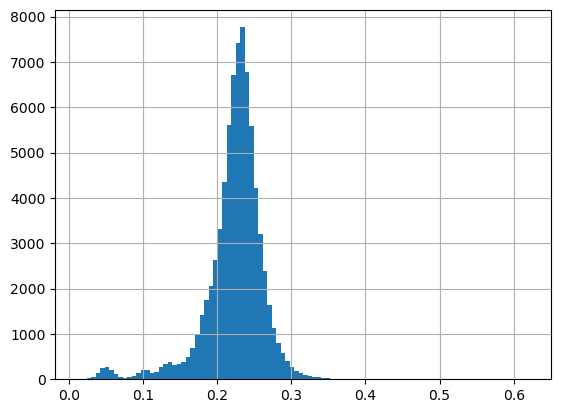

In [28]:
# Check if the matrix is upper triangular
is_upper_triangular = np.allclose(mean_matrix.values, np.triu(mean_matrix.values))

# Print the result
print("Is the matrix upper triangular?", is_upper_triangular)
mean_matrix
# unique values and distribution
long_table.occ_i.nunique(), long_table.occ_j.nunique(), long_table.Value.hist(bins = 100)

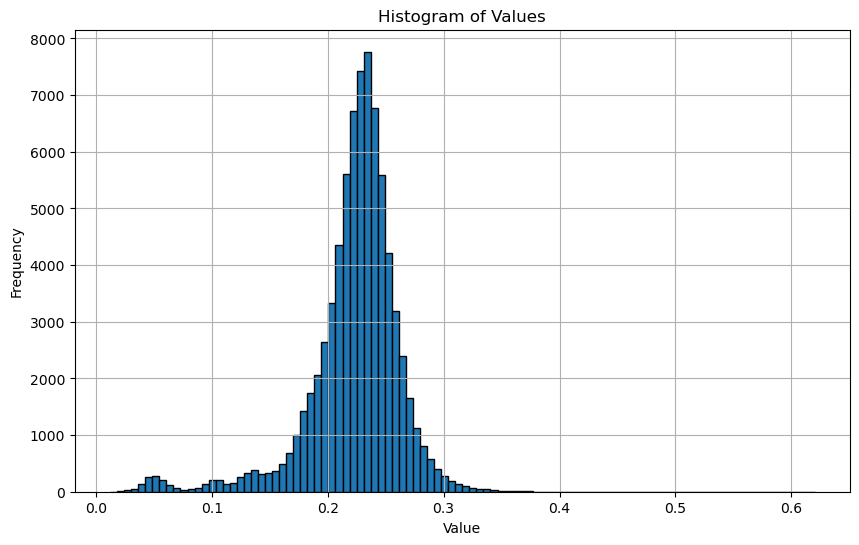

Unique occ_i: 392
Unique occ_j: 392
Histogram saved as ../figs_tabs/UK_modern_value_dist.png


In [32]:
# .save("../figs_tabs/value_dist.png")
import pandas as pd
import matplotlib.pyplot as plt

# Assuming long_table is your DataFrame
# Compute the unique counts
occ_i_unique = long_table.occ_i.nunique()
occ_j_unique = long_table.occ_j.nunique()

# Plot and save the histogram for Value column
plt.figure(figsize=(10, 6))
plt.hist(long_table['Value'], bins=100, edgecolor='k')
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig(fig_path)
plt.show()
fig_path = '../figs_tabs/UK_modern_value_dist.png'

plt.close()


print(f"Unique occ_i: {occ_i_unique}")
print(f"Unique occ_j: {occ_j_unique}")
print(f"Histogram saved as {fig_path}")


In [10]:
!ls -lha ../int_data/occ_space_chunks/occ_space_chunk* | wc -l

1189


# Start (depcrecated)

In [27]:
# %%time
# # 14.1 s for 2000 * 2000
# import numpy as np
# import pandas as pd

# # Number of unique i and j indices
# n = 20000

# # Generate random similarity values for the full matrix
# values = np.random.rand(n, n)

# # Create a DataFrame with all (i, j) pairs
# data = {
#     'i': np.repeat(np.arange(n), n),
#     'j': np.tile(np.arange(n), n),
#     'Value': values.flatten(),
#     'patent_id_i': [f'GB{np.random.randint(100000000, 999999999)}' for _ in range(n*n)],
#     'patent_id_j': [f'GB{np.random.randint(100000000, 999999999)}' for _ in range(n*n)]
# }

# df = pd.DataFrame(data)


KeyboardInterrupt: 

In [18]:
# %%time
# # Convert to NumPy array
# cosine_sim_long = df[['i', 'j', 'Value']].to_numpy()

NameError: name 'df' is not defined

In [19]:
%%time
# Convert to NumPy array
cosine_sim_long = cosine_sim_long[['i', 'j', 'Value']].to_numpy()

CPU times: user 18.9 s, sys: 18.1 s, total: 37 s
Wall time: 36.9 s


In [20]:
%%time

# Get the upper triangle (i < j)
upper = cosine_sim_long[cosine_sim_long[:, 0] < cosine_sim_long[:, 1]]

# Get the lower triangle (i > j)
lower = cosine_sim_long[cosine_sim_long[:, 0] > cosine_sim_long[:, 1]]

# Flip i and j in the lower triangle
lower_flipped = lower.copy()
lower_flipped[:, [0, 1]] = lower_flipped[:, [1, 0]]
print_ram_usage()

[0] RAM Usage: 97111.00 MB
CPU times: user 22.3 s, sys: 9.39 s, total: 31.7 s
Wall time: 31.7 s


In [21]:
%%time
# Combine the triangles
combined = np.concatenate((upper, lower_flipped), axis=0)

# Sum the values of the combined triangles by (i, j)
# Create a DataFrame for easier aggregation
combined_df = pd.DataFrame(combined, columns=['i', 'j', 'Value'])
print_ram_usage()


[0] RAM Usage: 108309.55 MB
CPU times: user 4.22 s, sys: 5.54 s, total: 9.77 s
Wall time: 9.73 s


In [22]:
upper.shape, lower.shape

((244636140, 3), (244636140, 3))

In [23]:
%%time

# Group by (i, j) and sum the 'Value' column
result_df = combined_df.groupby(['i', 'j'], as_index=False).sum()
print_ram_usage()
result_df

[0] RAM Usage: 121435.66 MB
CPU times: user 3min 33s, sys: 24.2 s, total: 3min 57s
Wall time: 3min 57s


,i,j,Value
0,0,1,0.178727
1,0,2,0.398073
2,0,3,0.464152
3,0,4,0.103452
4,0,5,0.045775
...,...,...,...
244636135,22116,22118,0.389079
244636136,22116,22119,0.440638
244636137,22117,22118,0.452911
244636138,22117,22119,0.518816


In [24]:
print_ram_usage()


[0] RAM Usage: 121435.66 MB


In [25]:
# Combine the triangles
combined = np.vstack((upper, lower_flipped))

# Using NumPy to sum values for (i, j) pairs efficiently
ij = combined[:, :2].astype(int)
values = combined[:, 2]

# Create an empty matrix for the summed values
summed_values = np.zeros((n, n))

# Sum the values into the matrix
for k in range(combined.shape[0]):
    i, j = ij[k]
    summed_values[i, j] += values[k]

# Convert the matrix to a DataFrame if needed
result_df = pd.DataFrame(summed_values)

# Display the result
print(result_df)

NameError: name 'n' is not defined

In [ ]:
# import pickle

# with open('../int_data/result_df.pkl','wb') as f:
#     pickle.dump(result_df, f)

In [ ]:
import pickle

with open('../int_data/result_df.pkl','rb') as f:
    result_df = pickle.load(f)

In [26]:
result_df

,i,j,Value
0,0,1,0.178727
1,0,2,0.398073
2,0,3,0.464152
3,0,4,0.103452
4,0,5,0.045775
...,...,...,...
244636135,22116,22118,0.389079
244636136,22116,22119,0.440638
244636137,22117,22118,0.452911
244636138,22117,22119,0.518816


In [9]:
%%time
print_ram_usage()

result_df['patent_id_i'] = result_df['i'].apply(lambda x:tab_i[x])
print_ram_usage()

result_df['patent_id_j'] = result_df['j'].apply(lambda x:tab_j[x])
print_ram_usage()

# result_df = pd.merge(left = result_df, right = cosine_sim_long[['j', 'patent_id_j']], left_on = 'j', right_on = 'j')

[0] RAM Usage: 11325.62 MB



KeyboardInterrupt



In [47]:
result_df.dtypes, type(result_df.Value.iloc[0])

(i              object
 j              object
 Value          object
 patent_id_i    object
 patent_id_j    object
 dtype: object,
 float)

In [51]:
result_df.patent_id_i.isnull().sum(), result_df.patent_id_j.isnull().sum()

(0, 0)

In [48]:
# result_df.to_csv('../final_data/result_22120.csv', index = False)

# Aggregation on occupation

In [2]:
import pandas as pd
# result_df = pd.read_csv('../final_data/result_22120.csv')
result_df = pd.read_feather('../final_data/result_22120.feather')

In [3]:
result_df

,i,j,Value,patent_id_i,patent_id_j
0,0,1,0.178727,GB187303416,GB187600824
1,0,2,0.398073,GB187303416,GB187601544
2,0,3,0.464152,GB187303416,GB188204200
3,0,4,0.103452,GB187303416,GB188803213
4,0,5,0.045775,GB187303416,GB188905132
...,...,...,...,...,...
244636135,22116,22118,0.389079,GB191213037,GB191217939
244636136,22116,22119,0.440638,GB191213037,GB191220302
244636137,22117,22118,0.452911,GB191213039,GB191217939
244636138,22117,22119,0.518816,GB191213039,GB191220302


## Exploding Input_patent_matrix to get OCC_SPACE (unique non-na occs)

In [4]:
data = pd.read_csv('../int_data/Input_patent_matrix.csv')
data['strcount'] = data['description'].str.split().str.len()
# Filter the data based on the word count
# Too long or too short patents are filtered
data = data[(data['strcount'] > 10) & (data['strcount'] <= 500)].reset_index(drop = True)
data = data[['i', 'occupation.x']].rename(columns = {"occupation.x":"census_occupation"})

# str -> list
data_explode_pre = data
import re
# To split a string by both ", " and "; "

data_explode_pre.census_occupation = data_explode_pre.census_occupation.apply(lambda x: re.split(r', |; ', x.strip().strip(',')))
# data_explode_pre.census_occupation = data_explode_pre.census_occupation.apply(lambda x:x.strip().strip(',').split(', '))

In [5]:
data_explode_pre

,i,census_occupation
0,GB187303416,"[HISCO410, HISCO744, HISCO896]"
1,GB187600824,"[HISCO779, HISCO951, HISCO813, HISCO896, HISCO..."
2,GB187601544,"[HISCO999, HISCO974, HISCO90, HISCO24, HISCO90..."
3,GB188204200,"[HISCO949, HISCO443, HISCO161, HISCO799, HISCO..."
4,GB188803213,[HISCO777]
...,...,...
22115,GB191211210,[NA]
22116,GB191213037,"[HISCO333, HISCO999, HISCO999, HISCO33, HISCO333]"
22117,GB191213039,"[HISCO333, HISCO999, HISCO999, HISCO33, HISCO333]"
22118,GB191217939,"[HISCO333, HISCO999, HISCO999, HISCO33, HISCO333]"


In [6]:
data_explode_pre.census_occupation[0][0]

'HISCO410'

In [7]:
data_exploded = data_explode_pre.explode('census_occupation').reset_index(drop = True)
data_exploded

,i,census_occupation
0,GB187303416,HISCO410
1,GB187303416,HISCO744
2,GB187303416,HISCO896
3,GB187600824,HISCO779
4,GB187600824,HISCO951
...,...,...
82481,GB191217939,HISCO999
82482,GB191217939,HISCO33
82483,GB191217939,HISCO333
82484,GB191220302,HISCO21


In [8]:
data_exploded = data_exploded[data_exploded.census_occupation != 'NA'].reset_index(drop = True)
data_exploded

,i,census_occupation
0,GB187303416,HISCO410
1,GB187303416,HISCO744
2,GB187303416,HISCO896
3,GB187600824,HISCO779
4,GB187600824,HISCO951
...,...,...
75038,GB191217939,HISCO999
75039,GB191217939,HISCO33
75040,GB191217939,HISCO333
75041,GB191220302,HISCO21


In [9]:
# data_exploded.census_occupation.nunique(), data_exploded.i.nunique(), data_exploded.census_occupation.count_values()

In [10]:
# All levels exploded?
data_exploded.len_census_occupation = data_exploded.census_occupation.apply(len)
data_exploded.len_census_occupation.value_counts()
# correct

/tmp/ipykernel_12628/166653217.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data_exploded.len_census_occupation = data_exploded.census_occupation.apply(len)


census_occupation
8    58260
7    16783
Name: count, dtype: int64

## create dictionary for looking up

In [98]:
# data_exploded.groupby('census_occupation').agg(lambda x:list(x))


## Aggregation

In [10]:
data

,i,census_occupation
0,GB187303416,"[HISCO410, HISCO744, HISCO896]"
1,GB187600824,"[HISCO779, HISCO951, HISCO813, HISCO896, HISCO..."
2,GB187601544,"[HISCO999, HISCO974, HISCO90, HISCO24, HISCO90..."
3,GB187901073,"[HISCO410, HISCO80, HISCO744, HISCO999, HISCO8..."
4,GB187901073,"[HISCO410, HISCO80, HISCO744, HISCO999, HISCO8..."
...,...,...
22139,GB191211210,[NA]
22140,GB191213037,"[HISCO333, HISCO999, HISCO999, HISCO33, HISCO333]"
22141,GB191213039,"[HISCO333, HISCO999, HISCO999, HISCO33, HISCO333]"
22142,GB191217939,"[HISCO333, HISCO999, HISCO999, HISCO33, HISCO333]"


In [11]:
result_df

,i,j,Value,patent_id_i,patent_id_j
0,0,1,0.178727,GB187303416,GB187600824
1,0,2,0.398073,GB187303416,GB187601544
2,0,3,0.464152,GB187303416,GB188204200
3,0,4,0.103452,GB187303416,GB188803213
4,0,5,0.045775,GB187303416,GB188905132
...,...,...,...,...,...
244636135,22116,22118,0.389079,GB191213037,GB191217939
244636136,22116,22119,0.440638,GB191213037,GB191220302
244636137,22117,22118,0.452911,GB191213039,GB191217939
244636138,22117,22119,0.518816,GB191213039,GB191220302


In [12]:
# result_df_bak = result_df
# result_df = result_df_bak.head(10000000)
# result_df = result_df_bak

NameError: name 'result_df_bak' is not defined

In [ ]:
%time
import numpy as np
import pandas as pd

# Step 1: Prepare necessary numpy arrays
value_array = result_df['Value'].values
patent_id_i_array = result_df['patent_id_i'].values
patent_id_j_array = result_df['patent_id_j'].values
census_occupation_array = data_exploded['census_occupation'].values
i_array = data_exploded['i'].values
print_ram_usage(1)

# Step 2: Merge result_df with data_exploded using numpy
def merge_with_numpy(value_array, patent_id_array, i_array, census_occupation_array):
    sort_idx = np.argsort(i_array)
    sorted_i = i_array[sort_idx]
    sorted_census_occupation = census_occupation_array[sort_idx]

    merged_values = []
    merged_census_occupations = []

    for patent_id, value in zip(patent_id_array, value_array):
        idx = np.searchsorted(sorted_i, patent_id)
        if idx < len(sorted_i) and sorted_i[idx] == patent_id:
            merged_values.append(value)
            merged_census_occupations.append(sorted_census_occupation[idx])

    return np.array(merged_values), np.array(merged_census_occupations)

values_i, census_occupations_i = merge_with_numpy(value_array, patent_id_i_array, i_array, census_occupation_array)
values_j, census_occupations_j = merge_with_numpy(value_array, patent_id_j_array, i_array, census_occupation_array)
print_ram_usage(2)

# Step 3: Combine results and drop NA
combined_values = np.concatenate([values_i, values_j])
combined_census_occupations = np.concatenate([census_occupations_i, census_occupations_j])

valid_idx = ~pd.isnull(combined_census_occupations)
combined_values = combined_values[valid_idx]
combined_census_occupations = combined_census_occupations[valid_idx]
print_ram_usage(3)

# Step 4: Group by census_occupation and compute the means using numpy
unique_occupations, inverse_idx = np.unique(combined_census_occupations, return_inverse=True)
sum_values = np.zeros(len(unique_occupations))
count_values = np.zeros(len(unique_occupations))
np.add.at(sum_values, inverse_idx, combined_values)
np.add.at(count_values, inverse_idx, 1)
mean_values = sum_values / count_values

aggregated_df = pd.DataFrame({'census_occupation': unique_occupations, 'Value': mean_values})
print_ram_usage(4)

# Step 5: Prepare pairwise combinations
occupations = data_exploded['census_occupation'].dropna().unique()
pairwise_combinations = pd.MultiIndex.from_product([occupations, occupations], names=['occupation_1', 'occupation_2']).to_frame(index=False)
pairwise_combinations = pairwise_combinations[pairwise_combinations.occupation_1 != pairwise_combinations.occupation_2]
print_ram_usage(5)

# Step 6: Merge pairwise_combinations with aggregated_df
aggregated_pairs = pd.merge(pairwise_combinations, aggregated_df, left_on='occupation_1', right_on='census_occupation', how='left').fillna(0)
aggregated_pairs = pd.merge(aggregated_pairs, aggregated_df, left_on='occupation_2', right_on='census_occupation', how='left').fillna(0)
print_ram_usage(6)

# Step 7: Calculate the combined value for each pair
aggregated_pairs['Combined_Value'] = (aggregated_pairs['Value_x'] + aggregated_pairs['Value_y']) / 2
print_ram_usage(7)

# Step 8: Drop intermediate columns
aggregated_pairs = aggregated_pairs[['occupation_1', 'occupation_2', 'Combined_Value']]
print_ram_usage(8)
aggregated_pairs

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.39 µs
[1] RAM Usage: 9703.96 MB


In [ ]:
combined_values, len(combined_values)

In [ ]:
combined_census_occupations, len(combined_census_occupations)

In [ ]:
aggregated_pairs.Combined_Value.value_counts()

In [ ]:
aggregated_pairs[aggregated_pairs.occupation_1 == aggregated_pairs.occupation_2]

In [ ]:
aggregated_pairs.to_feather('../final_data/agg_occ.feather')

In [ ]:
merged_df_j

In [ ]:
aggregated_pairs

In [ ]:
result_df_ij.len_patent_id_j_occ = result_df_ij.patent_id_j_occ.apply(len)
result_df_ij.len_patent_id_i_occ = result_df_ij.patent_id_i_occ.apply(len)
result_df_ij.len_patent_id_j_occ.value_counts(), result_df_ij.len_patent_id_i_occ.value_counts(), result_df_ij.patent_id_i.value_counts(), result_df_ij.patent_id_j.value_counts(), 

In [ ]:
aggregated_pairs

In [ ]:
result_df['patent_id_j_occ'] = pd.merge()

# merge

# find outer union of occs of id_i and id_j

# agg by occupations, and get (245 * 245 = ) 60,025 entries


In [ ]:
result_df = pd.merge(result_df, data_exploded, )

In [ ]:
# result_df.to_feather('../final_data/result_22120.feather')

In [ ]:
# TODO: aggregation on industry, occupation.y -> "census_occupation"
# Step 2:
# US census, patent data

In [ ]:
import pandas as pd
result_df = pd.read_feather('../final_data/result_22120.feather')

In [ ]:
result_df